https://colab.research.google.com/drive/1GF-DM1sDnmErwUquxEdl4OFfnUWcVu6G#scrollTo=QBCdRXdr2c0q

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# Load datasets
non_hostile = pd.read_csv("./src/non_hostile.csv")  # Contains 'Text', 'Label'
hostile = pd.read_csv("./src/hostile.csv")         # Contains 'Text', 'Label', 'SubLabel'

# Add SubLabel column to non-hostile and fill with 'None'
non_hostile['SubLabel'] = "None"

# Combine both datasets
data = pd.concat([non_hostile, hostile]).reset_index(drop=True)

## Remove All the Inconsistant Data

In [48]:
# Drop rows where any column has NaN or empty values
data = data.dropna()  # This removes rows where any value is NaN

# Additionally, remove rows where any column has empty strings or only spaces
data = data[~data.apply(lambda row: row.str.strip().eq('').any(), axis=1)]

# Ensure 'Label' is an integer (convert float to int if needed)
data['Label'] = data['Label'].astype(int)

# Extract distinct values
distinct_labels = data['Label'].unique()
distinct_sublabels = data['SubLabel'].unique()

# Print distinct values
print("Distinct Labels:", distinct_labels)
print("Distinct SubLabels:", distinct_sublabels)

Distinct Labels: [0 1]
Distinct SubLabels: ['None' 'Hate' 'Offensive' 'Defamation' 'Fake']


In [49]:
data['Label'] = data['Label'].replace({'Non-hostile': 0, 'Hostile': 1, 'hostile': 1})
data["BinaryLabel"] = (data["Label"] == 1.0).astype(int)
data.tail()

,Text,Label,SubLabel,BinaryLabel
14674,Bjp ના પોલીસ ના નખરા નઈ સહન કરવાના વિરોધ ની જર...,1,Offensive,1
14675,BJP ના લૂંટારા નેતા ઓ ની સાચેજ હવે ફાટવા લાગી ...,1,Defamation,1
14676,Bjp ના લોકો પાસે દંડ માંગવાની તેવડ નથી ગુલામી ...,1,Offensive,1
14677,Bjp ને વોટ ના આપો હજી ખરાબ હાલત કરશે આ બધા \r\n,1,Offensive,1
14678,BJP સરકાર માં પોલીસ ને પોતાની માં બહેનો ની પણ ...,1,Defamation,1


In [50]:
# divide the data into training val and test

train_texts, val_texts, train_binary_labels, val_binary_labels = train_test_split(
    data["Text"], data["BinaryLabel"], test_size=0.2, random_state=42
)

In [52]:
train_texts = [text for text in train_texts if isinstance(text, str)]
val_texts = [text for text in val_texts if isinstance(text, str)]

tfidf_binary = TfidfVectorizer(max_features=5000)
X_binary_train = tfidf_binary.fit_transform(train_texts)
X_binary_val = tfidf_binary.transform(val_texts)

# Vectorizer for Subclassification
tfidf_sub = TfidfVectorizer(max_features=5000)
X_sub_train = tfidf_sub.fit_transform(train_hostile_texts)
X_sub_val = tfidf_sub.transform(val_hostile_texts)

In [89]:
X_binary_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 163689 stored elements and shape (11740, 5000)>

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print(X_binary_train.shape[0], len(train_binary_labels))

# Align both the feature matrix and the labels
# If there are NaNs or missing labels, remove those rows
train_binary_labels = train_binary_labels[:X_binary_train.shape[0]]

# Now train the model
binary_model = LogisticRegression()
binary_model.fit(X_binary_train, train_binary_labels)
binary_preds = binary_model.predict(X_binary_val)

if len(binary_preds) != len(val_binary_labels):
    print("Mismatch in number of predictions and labels!")
    # Optional: Trim the longer array
    min_len = min(len(binary_preds), len(val_binary_labels))
    binary_preds = binary_preds[:min_len]
    val_binary_labels = val_binary_labels[:min_len]
    
    
# Evaluate the model performance
print("Binary Classification Accuracy:", accuracy_score(val_binary_labels, binary_preds))
print(classification_report(val_binary_labels, binary_preds))


11740 11740
Binary Classification Accuracy: 0.8534923339011925
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1469
           1       0.85      0.86      0.85      1466

    accuracy                           0.85      2935
   macro avg       0.85      0.85      0.85      2935
weighted avg       0.85      0.85      0.85      2935



In [70]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(binary_model, X_binary_train, train_binary_labels, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Cross-Validation Scores: [0.85136286 0.85391823 0.85689949 0.85306644 0.85051107]
Mean CV Score: 0.8531516183986371


In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(val_binary_labels, binary_preds)
auc = roc_auc_score(val_binary_labels, binary_preds)
print("AUC:", auc)


AUC: 0.853495663447492


In [106]:
import joblib
import shutil

# Save the fitted vectorizer
joblib.dump(tfidf_binary, 'tfidf_binary_vectorizer.pkl')

# Save the trained model
joblib.dump(binary_model, 'binary_classification_model.pkl')

# Copy the saved vectorizer and model to the specified directory
shutil.copy('tfidf_binary_vectorizer.pkl', '../backend/api/extensions/ml/tfidf_binary_vectorizer.pkl')
shutil.copy('binary_classification_model.pkl', '../backend/api/extensions/ml/binary_classification_model.pkl')

'../backend/api/extensions/ml/binary_classification_model.pkl'

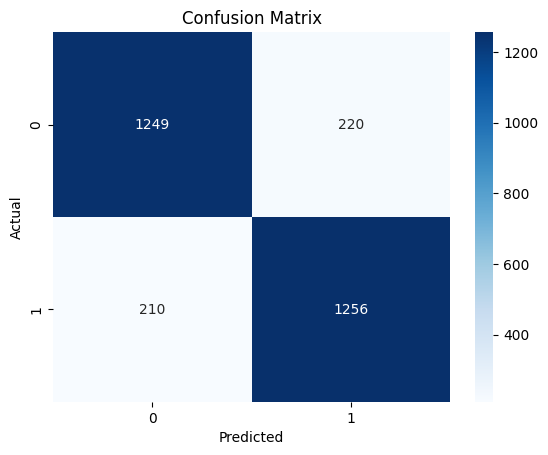

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_binary_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Test the Model on Prediction Now

In [104]:
# Ensure the tfidf_binary vectorizer is fitted
tfidf_binary = TfidfVectorizer(max_features=5000)
tfidf_binary.fit(train_texts)  # Fit the vectorizer on the training text data

def predict_tweet(text):
    # Preprocess the text (e.g., convert to lowercase)
    text = text.strip().lower()

    # Vectorize the tweet using the fitted vectorizer
    text_vectorized = tfidf_binary.transform([text])  # Use the fitted tfidf_binary

    # Predict using the trained model
    prediction = binary_model.predict(text_vectorized)

    # Return the prediction
    return prediction

# Example usage:
tweet = """આ લોકો છે, આ દુનિયામાં રહેવા લાયક. તેમને બસ જવા દો.
"""
prediction = predict_tweet(tweet)
print("Predicted Label for the tweet:", prediction)

Predicted Label for the tweet: [0]


----
----

# Lets Train For SubLabel Now
---

In [ ]:
# Filter out the hostile

hostile_data = data[data["BinaryLabel"] == 1]

train_hostile_texts, val_hostile_texts, train_sub_labels, val_sub_labels = train_test_split(
    hostile_data["Text"], hostile_data["SubLabel"], test_size=0.2, random_state=42
)

In [108]:
train_sub_texts = [text for text in train_hostile_texts if isinstance(text, str)]
val_sub_texts = [text for text in val_hostile_texts if isinstance(text, str)]

tfidf_sub = TfidfVectorizer(max_features=5000)
X_sub_train = tfidf_sub.fit_transform(train_sub_texts)
X_sub_val = tfidf_sub.transform(val_sub_texts)

# Vectorizer for Subclassification
tfidf_sub = TfidfVectorizer(max_features=5000)
X_sub_train = tfidf_sub.fit_transform(train_hostile_texts)
X_sub_val = tfidf_sub.transform(val_hostile_texts)

In [109]:
X_sub_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 72218 stored elements and shape (5821, 5000)>

In [117]:
print(X_sub_train.shape[0], len(train_sub_labels))

# Align both the feature matrix and the labels

train_sub_labels = train_sub_labels[:X_sub_train.shape[0]]

# Now train the model
sub_model = LogisticRegression()
sub_model.fit(X_sub_train, train_sub_labels)
sub_preds = sub_model.predict(X_sub_val)


# Data Should Stay Consistent Equal in Both the Feature Matrix and the Labels
if len(sub_preds) != len(val_sub_labels):
    print("Mismatch in number of predictions and labels!")
    
    min_sub_len = min(len(sub_preds), len(val_sub_labels))
    
    sub_preds = sub_preds[:min_sub_len]
    
    val_sub_labels = val_binary_labels[:min_sub_len]
    
# Evaluate the Model Performance

print(" Sub Performance Accuracy : " , accuracy_score(val_sub_labels, sub_preds))
print(classification_report(val_sub_labels, sub_preds))

5821 5821
 Sub Performance Accuracy :  0.4800824175824176
              precision    recall  f1-score   support

  Defamation       0.37      0.20      0.26       528
        Fake       0.00      0.00      0.00        51
        Hate       0.00      0.00      0.00       123
        None       0.00      0.00      0.00         7
   Offensive       0.51      0.79      0.62       747

    accuracy                           0.48      1456
   macro avg       0.17      0.20      0.18      1456
weighted avg       0.39      0.48      0.41      1456



c:\Users\Scarlett\Desktop\Project\FARM-Stack\AI-Tweet-Detector\ai-test\ai_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Scarlett\Desktop\Project\FARM-Stack\AI-Tweet-Detector\ai-test\ai_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Scarlett\Desktop\Project\FARM-Stack\AI-Tweet-Detector\ai-test\ai_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [118]:
sub_cv_scores = cross_val_score(sub_model, X_sub_train, train_sub_labels, cv=5)
print("Cross-Validation Scores:", sub_cv_scores)
print("Mean CV Score:", sub_cv_scores.mean())

Cross-Validation Scores: [0.49184549 0.46219931 0.5        0.46649485 0.46993127]
Mean CV Score: 0.4780941846230993


In [ ]:
# For Multiclass Problems, We Can Use the 'macro' Average [One-vs-Rest (OvR)]
from sklearn.multiclass import OneVsRestClassifier

sub_model = OneVsRestClassifier(LogisticRegression())
sub_model.fit(X_sub_train, train_sub_labels)

# Predict probabilities for the validation set
sub_preds = sub_model.predict_proba(X_sub_val)

# Calculate the ROC AUC score for the multiclass problem
sub_auc = roc_auc_score(val_sub_labels, sub_preds, average='macro', multi_class='ovr')
print("AUC:", sub_auc)

AUC: 0.5737861879475398


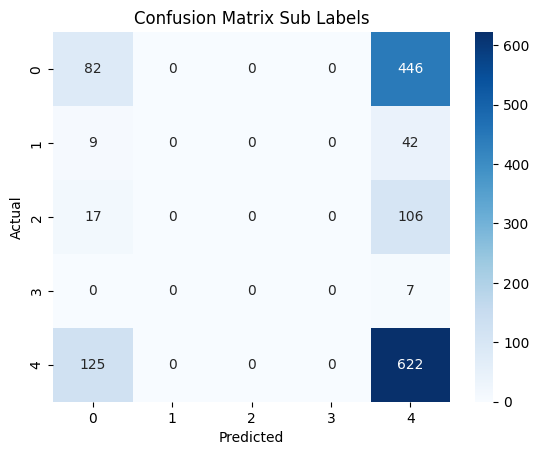

In [123]:
# Convert predicted probabilities to class labels
sub_preds_labels = sub_model.predict(X_sub_val)

# Compute the confusion matrix
sub_cm = confusion_matrix(val_sub_labels, sub_preds_labels)

# Plot the confusion matrix
sns.heatmap(sub_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Sub Labels')
plt.show()

In [ ]:
#Test the model

# Ensure the tfidf_sub vectorizer is fitted

tfidf_sub = TfidfVectorizer(max_features=5000)
tfidf_sub.fit(train_sub_texts)

def predict_sub_hostile(text):
    
    # Preprocess the text (e.g., convert to lowercase)
    text = text.strip().lower()

    # Vectorize the tweet using the fitted vectorizer
    text_vectorized = tfidf_sub.transform([text])  # Use the fitted tfidf_binary

    # Predict using the trained model
    prediction = sub_model.predict(text_vectorized)

    # Return the prediction
    return prediction[0]

# Example usage:
tweet = """આ લોકો કેટલી બેભાખ છે, આ દુનિયામાં રહેવા લાયક નથી. તેમને બસ જવા દો.
"""
prediction = predict_sub_hostile(tweet)
print("Predicted Label for the tweet:", prediction)

Predicted Label for the tweet: ['Offensive']


In [127]:
#Export Our Sublabel Predictor Model

joblib.dump(tfidf_sub, 'tfidf_sub_vectorizer.pkl')
joblib.dump(sub_model, "sub_classification_model.pkl")

shutil.copy('tfidf_sub_vectorizer.pkl', '../backend/api/extensions/ml/tfidf_sub_vectorizer.pkl')
shutil.copy('sub_classification_model.pkl', '../backend/api/extensions/ml/sub_classification_model.pkl')

'../backend/api/extensions/ml/sub_classification_model.pkl'